In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tiktoken

In [ ]:
!pip install openai

In [ ]:
import requests
import re
import urllib.request
import time
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import pandas as pd
import numpy as np
import tiktoken
import openai
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

In [ ]:
#APIキーを環境変数に設定
os.environ['OPENAI_API_KEY'] = ''

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
#URLに適合する正規表現パターン
HTTP_URL_PATTERN = r'^http[s]*://.+'

In [ ]:
#クロールしたいwebサイトのドメインとURLを設定
domain = ""
full_url = ""

# クロールするディレクトリを指定
directory_path = ""

In [ ]:
#HTMLを解析し、ハイパーリンクの一覧を取得するためのクラス定義
class HyperlinkParser(HTMLParser):
  def __init__(self):
    super().__init__()
    self.hyperlinks = []

  ## ハイパーリンクを取得するために、HTMLParserのhandle_starttagメソッドをオーバーライド
  def handle_starttag(self, tag, attrs):
    attrs = dict(attrs)
    #aタグかつhrefがある場合、辞書型のattrsからurlを抜き出し、リストに加える
    if tag == "a" and "href" in attrs:
      self.hyperlinks.append(attrs["href"])

#ハイパーリンクをURLから取得する関数を定義
def get_hyperlinks(url):
  #URLをオープンし、読み込む処理をtry
  try:
    # HTMLページを取得
    with urllib.request.urlopen(url) as response:
      #もしContent-Typeがhtmlでなかった場合はからのリストを返却
      if not response.info().get("Content-Type", "").startswith("text/html"):
        return []
      #htmlをutf-8形式にデコード
      html = response.read().decode("utf-8")
  except requests.exceptions.HTTPError as e:
    print(e)
    return []
  except requests.exceptions.RequestException as e:
    print(e)
    return []

  #HyperlinkParserクラスのオブジェクト生成
  parser = HyperlinkParser()
  #HTMLを解析し、ハイパーリンクのリストを生成
  parser.feed(html)

  return parser.hyperlinks

In [ ]:
def get_domain_hyperlinks(local_domain, url, directory_path=""):
  #ドメインにあったURLを格納するためのからのリストを作成
  clean_links = []
  for link in set(get_hyperlinks(url)):
    #ドメイン一致するリンクを格納する変数の初期化
    clean_link = None

    try:
    #与えられたリンクがURLの正規表現にマッチするか判定
      if re.search(HTTP_URL_PATTERN, link):
        #リンクをパースし、URLの各部分をタプル形で格納
        url_obj = urlparse(link)

        #URLのネットワーク位置が取得したいドメインと一致しているか判別
        if url_obj.netloc == local_domain:
          #一致していた場合、ドメイン一致リンクとしてclean_link関数に格納
          clean_link = link
      else:
        #相対パスで記述されているものを判定し、絶対パスへ変換するための前処理を行う
        if link.startswith("/"):
          link = link[1:]

        #リンクが#やmailto:などの場合、continueでループ処理をスキップ
        elif link.startswith("#") or link.startswith("mailto:"):
          continue
        #相対パスから絶対パスを生成
        clean_link = "https://" + local_domain + "/" + link
    except:
      print("miss")
      continue

    #ここまでの処理でドメインと一致するURLリンクが得られていれば処理を実行
    if clean_link is not None:
      if clean_link.endswith("/"):
        clean_link = clean_link[:-1]

      # directory_pathが空でない場合、リンクがそのディレクトリ内にあることを確認。そうでない場合は次のループへ
      if directory_path and not clean_link.startswith(f"https://{local_domain}/{directory_path}"):
        continue

      clean_links.append(clean_link)

  #最後にclean_linkリストを返却
  return list(set(clean_links))

In [ ]:
#ディレクトリ作成を関数化
def create_directory_if_not_exists(directory):
  if not os.path.exists(directory):
    os.mkdir(directory)

def crawl(url, directory_path=""):
  #URLをパースし、ドメインを取得
  local_domain = urlparse(url).netloc

  #もしディレクトリが指定されている場合は、ディレクトリパスを含めたurlへ上書き
  if directory_path:
    url = f"https://{local_domain}/{directory_path}"

  #クロールするURLの一覧を格納するキューを作成
  queue = deque([url])
  #すでに処理済みのURLを格納するための変数を作成
  seen = set([url])

  #textディレクトリがない場合は作成
  create_directory_if_not_exists("text/")
  #text/local_domainがない場合は作成
  create_directory_if_not_exists(f"text/{local_domain}/")
  #processedディレクトリを作成
  create_directory_if_not_exists("processed")

  while queue:
    url = queue.pop()

    #text/local_domain配下にtxtファイルを作成
    with open(f"text/{local_domain}/{url[8:].replace('/', '_')}.txt", "w", encoding="UTF-8") as f:
      # BeautifulSoupを用いてHTMLを解析し、get_textメソッドでtextを抽出し
      try:
        response = requests.get(url, timeout=(3.0, 7.5))
        time.sleep(0.2)

        #レスポンスのステータスコードが200以外の場合ループをスキップ
        if response.status_code != 200:
          print(f"Unable to fetch page {url}: Status code {response.status_code}")
          continue
        #Content-Typeがtext/htmlでない場合処理をスキップ
        content_type = response.headers.get('content-type')
        if not content_type or not content_type.startswith("text/html"):
          continue
        #レスポンスのHTMLを文字にデコード
        html = response.content.decode("utf-8")
        soup = BeautifulSoup(html, "html.parser")

        #後のテキスト情報最適化のためにheaderタグを削除
        header_tag = soup.find('header')
        if header_tag:
          header_tag.decompose()

        #後のテキスト情報最適化のためにfooterタグを削除
        footer_tag = soup.find('footer')
        if footer_tag:
          footer_tag.decompose()

        #後のテキスト情報最適化のためにheadタグを削除
        head_tag = soup.find('head')
        if head_tag:
          head_tag.decompose()

        #htmlを文字情報として取得
        text = soup.get_text()

        #textの中に下記エラーあった場合は処理をスキップ
        if ("You need to enable JavaScript to run this app." in text):
          print("Unable to parse page " + url + " due to JavaScript being required")
          continue
        #抽出したテキストをファイルに書き込む
        f.write(text)
        print(f"Able to fetch page {url}")
      except requests.exceptions.Timeout as e: # タイムアウトの例外処理
        print(f"Unable to fetch page {url}: Timeout")
        continue
      except Exception as e:
          print(f"Fault to write text. Unable to fetch page {url}: {str(e)}")
          continue

    #urlからHTMLに含まれるリンク一覧を取得し、queueに含め、queueに含めたリンクをseenに追加
    for link in get_domain_hyperlinks(local_domain, url, directory_path):
        if link not in seen:
            queue.append(link)
            seen.add(link)

In [ ]:
crawl(full_url, directory_path)

In [ ]:
def remove_newlines(serie):
  serie = serie.str.replace('\n', ' ')
  serie = serie.str.replace('\\n', ' ')
  serie = serie.str.replace('  ', ' ')
  serie = serie.str.replace('  ', ' ')
  return serie

In [ ]:
texts = []

#text/domai配下のファイルをひとつづつ取得
for file in os.listdir(f"text/{domain}/"):
  #テキスト情報に処理を加えながら、textsリストに追加
  with open(f"text/{domain}/{file}", "r", encoding="UTF-8") as f:
    text = f.read()
    texts.append((file[len(domain)+2:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

In [ ]:
#textsをdfに変換し、scraped.csvとしてcsvリスト化
df = pd.DataFrame(texts, columns = ["fname", "text"])
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

In [ ]:
#ada-002モデルに適合するcl100k_baseトークナイザーをロード
tokenizer = tiktoken.get_encoding("cl100k_base")

In [ ]:
#processedディレクトリからcsvを読み込み、dfのカラムを変更する。
df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

#dfテキストをトークン化し、数を取得。その値を新しいn_tokensカラムに格納
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

<Axes: >

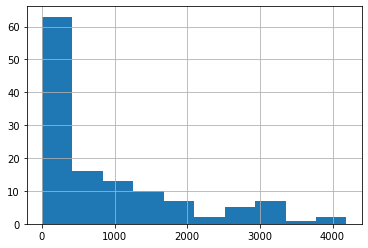

In [ ]:
#トークンの数をヒストグラムで描画
df.n_tokens.hist()

In [ ]:
#トークンの最大数を500に設定
max_tokens = 500

def split_into_many(text, max_tokens = max_tokens):
    #テキストをセンテンスに分割。日本語のサイトの場合は句点などで区切る必要がある。
    sentences = text.split(". ")
    #リスト内包表記を用いてセンテンスごとのトークン数を取得
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    #分割されたtextを格納するchunksを作成
    chunks = []
    #作成中のチャンクに含まれるトークン数
    tokens_so_far = 0
    #現在のチャンクに含まれる文のリスト
    chunk = []

    #sentencesとn_tokensの2変数をzip関数を用いて同時にループ処理
    for sentence, token in zip(sentences, n_tokens):
      if tokens_so_far + token > max_tokens:
        chunks.append(". ".join(chunk) + ".")
        chunk = []
        tokens_so_far = 0

      if token > max_tokens:
        continue

      chunk.append(sentence)
      tokens_so_far += token + 1

    return chunks

,text,n_tokens,embeddings
0,asic layout gridview.,5,"[-0.030038587749004364, 0.012473409995436668, ..."
1,pecial #transparent.,5,"[-0.018643205985426903, -0.010316913947463036,..."
2,tandard #logo2 header.,8,"[-0.024447718635201454, 0.01783481054008007, -..."
3,nackbar.,4,"[-0.010089077055454254, -0.03452230617403984, ..."
4,asic dialogs. ダイアログ・アラート | Flutter Doc JP記事一覧ホ...,472,"[-0.027180789038538933, 0.00913521833717823, 0..."


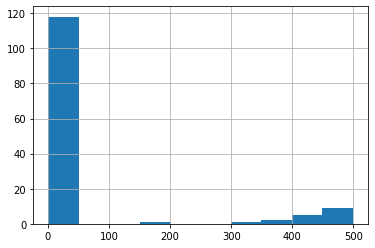

In [ ]:
shortened = []

for row in df.iterrows():
  #row[0]はindex。row[1]のtupleのtextが存在するか確認
  if row[1]["text"] is None:
    continue
  #row[1]のテクストがmax_tokensを超える場合、分割し、shortendに追加
  if row[1]["n_tokens"] > max_tokens:
    shortened += split_into_many(row[1]['text'])
  else:
    shortened.append( row[1]['text'] )

#shortenedされた文字のリストから新たなdfを生成
df = pd.DataFrame(shortened, columns = ['text'])
#dfの各行ごとのtoken数を取得しn_token列に格納
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

#textの値を引数にopenAIのtext embedding関数に渡し、数値ベクトル化する。その値をembeddings列に追加する
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
#dfをembeddins.csvとして出力
df.to_csv('processed/embeddings.csv')
df.head()

#embeddings.csvをdfとして読み込み
df=pd.read_csv('processed/embeddings.csv', index_col=0)
#文字列で保存されているembeddingsをevalでリスト化、さらにnp.arrayでnumpy配列にする
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()

In [ ]:
#データフレームから最も類似した文脈を見つけ、質問に対する文脈を作成する
def create_context(question, df, max_len=1800, size="ada"):

    #与えられた質問を数値ベクトル化し、変数に格納
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    #質問の埋め込みベクトルとデータフレーム内の各文の埋め込みベクトルとの間の距離を計算して、df データフレームに distances という列として追加
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    #返却される質問を格納するリストを定義
    returns = []
    #文章のトークン数をカウントす変数を定義
    cur_len = 0

    #dfのdistanceを照準に並べ、ループ処理を実行
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        #トークンをカウントする変数に現在のrowのトークン数をかさん
        cur_len += row['n_tokens'] + 4

        #cur_lenがmax_lenを超えた場合、処理を終了
        if cur_len > max_len:
            break

        #トークン数がmax_tokenを超えない場合、類似度が高い文章からreturnsに格納
        returns.append(row["text"])

    #抽出された類似度の高いテキストを一つの文章として返却
    return "\n\n###\n\n".join(returns)

In [ ]:
#データフレームの中から質問に類似した文脈を取得し、回答を取得する関数を作成
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=True,
    max_tokens=150,
    stop_sequence=None
):

  #create_context関数を実行し、質問と類似度の高い文章を抽出
  context = create_context(
      question,
      df,
      max_len=max_len,
      size=size,
  )
  # デバッグがTrueの場合返却された文章を表示
  if debug:
      print("Context:\n" + context)
      print("\n\n")

  try:
      #Questionとcontextを用いてAIモデルにリクエストを実行
      response = openai.Completion.create(
          prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
          temperature=0,
          max_tokens=max_tokens,
          top_p=1,
          frequency_penalty=0,
          presence_penalty=0,
          stop=stop_sequence,
          model=model,
      )
      #Json形式のレスポンスから回答を取得
      return response["choices"][0]["text"].strip()
  except Exception as e:
      print(e)
      return ""

In [ ]:
answer_question(df, question="Flutterで画面遷移を実現するにはどうすべきですか？手順を教えてください")

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")

completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": "Please tell me the starts of universe"}
  ],
  max_tokens=150
)

print(completion.choices[0].message)